In [2]:
from __future__ import print_function, division
import numpy as np
import math
from utils import normalize, polynomial_features

class l1_regularization():
    """ Regularization for Lasso Regression """
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * np.linalg.norm(w)

    def grad(self, w):
        return self.alpha * np.sign(w)

class l2_regularization():
    """ Regularization for Ridge Regression """
    def __init__(self, alpha):
        self.alpha = alpha
    
    def __call__(self, w):
        return self.alpha * 0.5 *  w.T.dot(w)

    def grad(self, w):
        return self.alpha * w

class l1_l2_regularization():
    """ Regularization for Elastic Net Regression """
    def __init__(self, alpha, l1_ratio=0.5):
        self.alpha = alpha
        self.l1_ratio = l1_ratio

    def __call__(self, w):
        l1_contr = self.l1_ratio * np.linalg.norm(w)
        l2_contr = (1 - self.l1_ratio) * 0.5 * w.T.dot(w) 
        return self.alpha * (l1_contr + l2_contr)

    def grad(self, w):
        l1_contr = self.l1_ratio * np.sign(w)
        l2_contr = (1 - self.l1_ratio) * w
        return self.alpha * (l1_contr + l2_contr) 

class Regression(object):
    """ Base regression model. Models the relationship between a scalar dependent variable y and the independent 
    variables X. 
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, n_iterations, learning_rate):
        self.n_iterations = n_iterations
        self.learning_rate = learning_rate

    def initialize_weights(self, n_features):
        """ Initialize weights randomly [-1/N, 1/N] """
        limit = 1 / math.sqrt(n_features)
        self.w = np.random.uniform(-limit, limit, (n_features, ))

    def fit(self, X, y):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        self.training_errors = []
        self.initialize_weights(n_features=X.shape[1])

        # Do gradient descent for n_iterations
        for i in range(self.n_iterations):
            y_pred = X.dot(self.w)
            # Calculate l2 loss
            mse = np.mean(0.5 * (y - y_pred)**2 + self.regularization(self.w))
            self.training_errors.append(mse)
            # Gradient of l2 loss w.r.t w
            grad_w = -(y - y_pred).dot(X) + self.regularization.grad(self.w)
            # Update the weights
            self.w -= self.learning_rate * grad_w

    def predict(self, X):
        # Insert constant ones for bias weights
        X = np.insert(X, 0, 1, axis=1)
        y_pred = X.dot(self.w)
        return y_pred

class LinearRegression(Regression):
    """Linear model.
    Parameters:
    -----------
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    gradient_descent: boolean
        True or false depending if gradient descent should be used when training. If 
        false then we use batch optimization by least squares.
    """
    def __init__(self, n_iterations=100, learning_rate=0.001, gradient_descent=True):
        self.gradient_descent = gradient_descent
        # No regularization
        self.regularization = lambda x: 0
        self.regularization.grad = lambda x: 0
        super(LinearRegression, self).__init__(n_iterations=n_iterations,
                                            learning_rate=learning_rate)
    def fit(self, X, y):
        # If not gradient descent => Least squares approximation of w
        if not self.gradient_descent:
            # Insert constant ones for bias weights
            X = np.insert(X, 0, 1, axis=1)
            # Calculate weights by least squares (using Moore-Penrose pseudoinverse)
            U, S, V = np.linalg.svd(X.T.dot(X))
            S = np.diag(S)
            X_sq_reg_inv = V.dot(np.linalg.pinv(S)).dot(U.T)
            self.w = X_sq_reg_inv.dot(X.T).dot(y)
        else:
            super(LinearRegression, self).fit(X, y)

class LassoRegression(Regression):
    """Linear regression model with a regularization factor which does both variable selection 
    and regularization. Model that tries to balance the fit of the model with respect to the training 
    data and the complexity of the model. A large regularization factor with decreases the variance of 
    the model and do para.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, reg_factor, n_iterations=3000, learning_rate=0.01):
        self.degree = degree
        self.regularization = l1_regularization(alpha=reg_factor)
        super(LassoRegression, self).__init__(n_iterations, 
                                            learning_rate)

    def fit(self, X, y):
        X = normalize(polynomial_features(X, degree=self.degree))
        super(LassoRegression, self).fit(X, y)

    def predict(self, X):
        X = normalize(polynomial_features(X, degree=self.degree))
        return super(LassoRegression, self).predict(X)

class PolynomialRegression(Regression):
    """Performs a non-linear transformation of the data before fitting the model
    and doing predictions which allows for doing non-linear regression.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, n_iterations=3000, learning_rate=0.001):
        self.degree = degree
        # No regularization
        self.regularization = lambda x: 0
        self.regularization.grad = lambda x: 0
        super(PolynomialRegression, self).__init__(n_iterations=n_iterations,
                                                learning_rate=learning_rate)

    def fit(self, X, y):
        X = polynomial_features(X, degree=self.degree)
        super(PolynomialRegression, self).fit(X, y)

    def predict(self, X):
        X = polynomial_features(X, degree=self.degree)
        return super(PolynomialRegression, self).predict(X)

class RidgeRegression(Regression):
    """Also referred to as Tikhonov regularization. Linear regression model with a regularization factor.
    Model that tries to balance the fit of the model with respect to the training data and the complexity
    of the model. A large regularization factor with decreases the variance of the model.
    Parameters:
    -----------
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, reg_factor, n_iterations=1000, learning_rate=0.001):
        self.regularization = l2_regularization(alpha=reg_factor)
        super(RidgeRegression, self).__init__(n_iterations, 
                                            learning_rate)

class PolynomialRidgeRegression(Regression):
    """Similar to regular ridge regression except that the data is transformed to allow
    for polynomial regression.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree, reg_factor, n_iterations=3000, learning_rate=0.01, gradient_descent=True):
        self.degree = degree
        self.regularization = l2_regularization(alpha=reg_factor)
        super(PolynomialRidgeRegression, self).__init__(n_iterations, 
                                                        learning_rate)

    def fit(self, X, y):
        X = normalize(polynomial_features(X, degree=self.degree))
        super(PolynomialRidgeRegression, self).fit(X, y)

    def predict(self, X):
        X = normalize(polynomial_features(X, degree=self.degree))
        return super(PolynomialRidgeRegression, self).predict(X)

class ElasticNet(Regression):
    """ Regression where a combination of l1 and l2 regularization are used. The
    ratio of their contributions are set with the 'l1_ratio' parameter.
    Parameters:
    -----------
    degree: int
        The degree of the polynomial that the independent variable X will be transformed to.
    reg_factor: float
        The factor that will determine the amount of regularization and feature
        shrinkage. 
    l1_ration: float
        Weighs the contribution of l1 and l2 regularization.
    n_iterations: float
        The number of training iterations the algorithm will tune the weights for.
    learning_rate: float
        The step length that will be used when updating the weights.
    """
    def __init__(self, degree=1, reg_factor=0.05, l1_ratio=0.5, n_iterations=3000, 
                learning_rate=0.01):
        self.degree = degree
        self.regularization = l1_l2_regularization(alpha=reg_factor, l1_ratio=l1_ratio)
        super(ElasticNet, self).__init__(n_iterations, 
                                        learning_rate)

    def fit(self, X, y):
        X = normalize(polynomial_features(X, degree=self.degree))
        super(ElasticNet, self).fit(X, y)

    def predict(self, X):
        X = normalize(polynomial_features(X, degree=self.degree))
        return super(ElasticNet, self).predict(X)


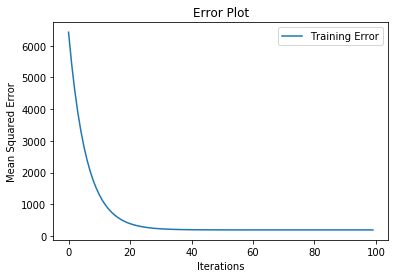

Mean squared error: 184.0442712304079


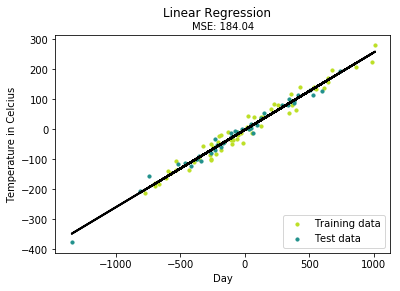

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

from utils import train_test_split, polynomial_features
from utils import mean_squared_error, Plot

def main():

    X, y = make_regression(n_samples=100, n_features=1, noise=20)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    n_samples, n_features = np.shape(X)

    model = LinearRegression(n_iterations=100)

    model.fit(X_train, y_train)
    
    # Training error plot
    n = len(model.training_errors)
    training, = plt.plot(range(n), model.training_errors, label="Training Error")
    plt.legend(handles=[training])
    plt.title("Error Plot")
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Iterations')
    plt.show()

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print ("Mean squared error: %s" % (mse))

    y_pred_line = model.predict(X)

    # Color map
    cmap = plt.get_cmap('viridis')

    # Plot the results
    m1 = plt.scatter(366 * X_train, y_train, color=cmap(0.9), s=10)
    m2 = plt.scatter(366 * X_test, y_test, color=cmap(0.5), s=10)
    plt.plot(366 * X, y_pred_line, color='black', linewidth=2, label="Prediction")
    plt.suptitle("Linear Regression")
    plt.title("MSE: %.2f" % mse, fontsize=10)
    plt.xlabel('Day')
    plt.ylabel('Temperature in Celcius')
    plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
    plt.show()

main()

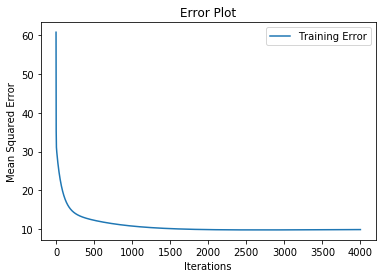

Mean squared error: 12.394954575062558 (given by reg. factor: 0.05)


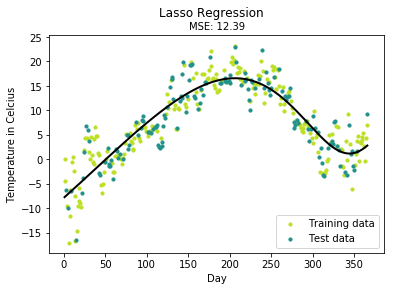

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression

from utils import train_test_split, polynomial_features
from utils import mean_squared_error, Plot

def main():

    # Load temperature data
    data = pd.read_csv('TempLinkoping2016.txt', sep="\t")

    time = np.atleast_2d(data["time"].values).T
    temp = data["temp"].values

    X = time # fraction of the year [0, 1]
    y = temp

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    poly_degree = 13

    model = LassoRegression(degree=15, 
                            reg_factor=0.05,
                            learning_rate=0.001,
                            n_iterations=4000)
    model.fit(X_train, y_train)

    # Training error plot
    n = len(model.training_errors)
    training, = plt.plot(range(n), model.training_errors, label="Training Error")
    plt.legend(handles=[training])
    plt.title("Error Plot")
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Iterations')
    plt.show()

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print ("Mean squared error: %s (given by reg. factor: %s)" % (mse, 0.05))

    y_pred_line = model.predict(X)

    # Color map
    cmap = plt.get_cmap('viridis')

    # Plot the results
    m1 = plt.scatter(366 * X_train, y_train, color=cmap(0.9), s=10)
    m2 = plt.scatter(366 * X_test, y_test, color=cmap(0.5), s=10)
    plt.plot(366 * X, y_pred_line, color='black', linewidth=2, label="Prediction")
    plt.suptitle("Lasso Regression")
    plt.title("MSE: %.2f" % mse, fontsize=10)
    plt.xlabel('Day')
    plt.ylabel('Temperature in Celcius')
    plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
    plt.show()


main()

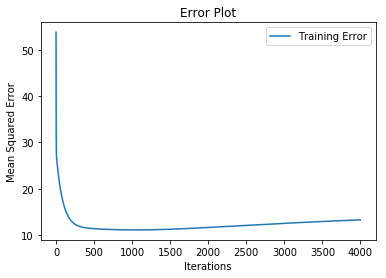

Mean squared error: 14.128280174889703 (given by reg. factor: 0.05)


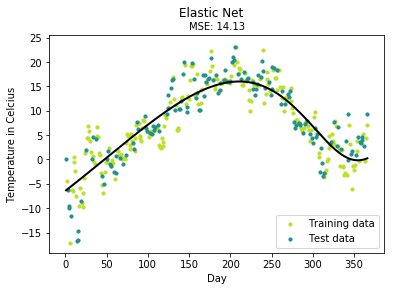

In [5]:
def main():

    # Load temperature data
    data = pd.read_csv('TempLinkoping2016.txt', sep="\t")

    time = np.atleast_2d(data["time"].values).T
    temp = data["temp"].values

    X = time # fraction of the year [0, 1]
    y = temp

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    poly_degree = 13

    model = ElasticNet(degree=15, 
                        reg_factor=0.01,
                        l1_ratio=0.7,
                        learning_rate=0.001,
                        n_iterations=4000)
    model.fit(X_train, y_train)

    # Training error plot
    n = len(model.training_errors)
    training, = plt.plot(range(n), model.training_errors, label="Training Error")
    plt.legend(handles=[training])
    plt.title("Error Plot")
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Iterations')
    plt.show()

    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print ("Mean squared error: %s (given by reg. factor: %s)" % (mse, 0.05))

    y_pred_line = model.predict(X)

    # Color map
    cmap = plt.get_cmap('viridis')

    # Plot the results
    m1 = plt.scatter(366 * X_train, y_train, color=cmap(0.9), s=10)
    m2 = plt.scatter(366 * X_test, y_test, color=cmap(0.5), s=10)
    plt.plot(366 * X, y_pred_line, color='black', linewidth=2, label="Prediction")
    plt.suptitle("Elastic Net")
    plt.title("MSE: %.2f" % mse, fontsize=10)
    plt.xlabel('Day')
    plt.ylabel('Temperature in Celcius')
    plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
    plt.show()

main()


Finding regularization constant using cross validation:
	Mean Squared Error: 10.79341627488097 (regularization: 0.0)
	Mean Squared Error: 10.954292486628724 (regularization: 0.01)
	Mean Squared Error: 10.991384784079443 (regularization: 0.02)
	Mean Squared Error: 11.311278950804688 (regularization: 0.03)
	Mean Squared Error: 11.30774818827144 (regularization: 0.04)
	Mean Squared Error: 11.118036570914068 (regularization: 0.05)
	Mean Squared Error: 11.261325129272283 (regularization: 0.06)
	Mean Squared Error: 11.589673852090097 (regularization: 0.07)
	Mean Squared Error: 11.763706519797847 (regularization: 0.08)
	Mean Squared Error: 11.37458990553939 (regularization: 0.09)
Mean squared error: 10.79341627488097 (given by reg. factor: 0.0)


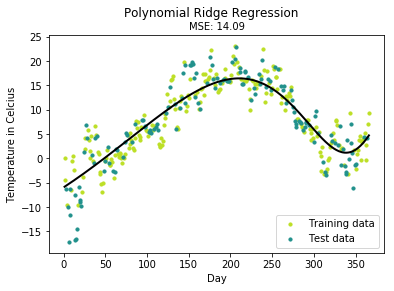

In [7]:
# Import helper functions
from utils import k_fold_cross_validation_sets, normalize, mean_squared_error
from utils import train_test_split, polynomial_features, Plot


def main():

    # Load temperature data
    data = pd.read_csv('TempLinkoping2016.txt', sep="\t")

    time = np.atleast_2d(data["time"].values).T
    temp = data["temp"].values

    X = time # fraction of the year [0, 1]
    y = temp

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)

    poly_degree = 15

    # Finding regularization constant using cross validation
    lowest_error = float("inf")
    best_reg_factor = None
    print ("Finding regularization constant using cross validation:")
    k = 10
    for reg_factor in np.arange(0, 0.1, 0.01):
        cross_validation_sets = k_fold_cross_validation_sets(
            X_train, y_train, k=k)
        mse = 0
        for _X_train, _X_test, _y_train, _y_test in cross_validation_sets:
            model = PolynomialRidgeRegression(degree=poly_degree, 
                                            reg_factor=reg_factor,
                                            learning_rate=0.001,
                                            n_iterations=10000)
            model.fit(_X_train, _y_train)
            y_pred = model.predict(_X_test)
            _mse = mean_squared_error(_y_test, y_pred)
            mse += _mse
        mse /= k

        # Print the mean squared error
        print ("\tMean Squared Error: %s (regularization: %s)" % (mse, reg_factor))

        # Save reg. constant that gave lowest error
        if mse < lowest_error:
            best_reg_factor = reg_factor
            lowest_error = mse

    # Make final prediction
    model = PolynomialRidgeRegression(degree=poly_degree, 
                                    reg_factor=best_reg_factor,
                                    learning_rate=0.001,
                                    n_iterations=10000)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print ("Mean squared error: %s (given by reg. factor: %s)" % (lowest_error, best_reg_factor))

    y_pred_line = model.predict(X)

    # Color map
    cmap = plt.get_cmap('viridis')

    # Plot the results
    m1 = plt.scatter(366 * X_train, y_train, color=cmap(0.9), s=10)
    m2 = plt.scatter(366 * X_test, y_test, color=cmap(0.5), s=10)
    plt.plot(366 * X, y_pred_line, color='black', linewidth=2, label="Prediction")
    plt.suptitle("Polynomial Ridge Regression")
    plt.title("MSE: %.2f" % mse, fontsize=10)
    plt.xlabel('Day')
    plt.ylabel('Temperature in Celcius')
    plt.legend((m1, m2), ("Training data", "Test data"), loc='lower right')
    plt.show()

main()
